# Perkenalan :

Nama : Dimas Liu

Batch : 001 

# Library Import :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library for Modelling :

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import IsolationForest

In [3]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# Data Loading :

In [4]:
df = pd.read_csv('Life_expectancy_dataset.csv')

In [5]:
df

,Rank,Country,Overall Life,Male Life,Female Life,Continent
0,1,Monaco,89.5,85.6,93.5,Europe
1,2,Japan,85.0,81.7,88.5,Asia
2,3,Singapore,85.0,82.3,87.8,Asia
3,4,Macau; China,84.5,81.6,87.6,Asia
4,5,San Marino,83.3,80.7,86.1,Europe
...,...,...,...,...,...,...
218,219,Gabon,52.1,51.6,52.5,Africa
219,220,Swaziland,51.6,52.2,51.0,Africa
220,221,Afghanistan,51.3,49.9,52.7,Asia
221,222,Guinea-Bissau,50.6,48.6,52.7,Africa


# Data Cleaning :

In [6]:
df.isna().sum()

Rank            0
Country         0
Overall Life    0
Male Life       0
Female Life     0
Continent       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          223 non-null    int64  
 1   Country       223 non-null    object 
 2   Overall Life  223 non-null    float64
 3   Male Life     223 non-null    float64
 4   Female Life   223 non-null    float64
 5   Continent     223 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.6+ KB


# EDA :

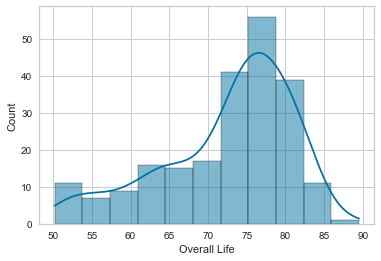

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Overall Life', kde=True);

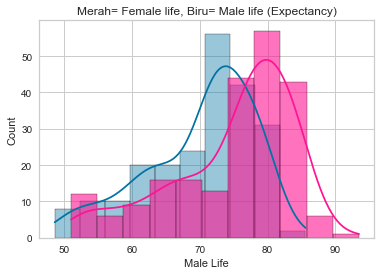

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Male Life', kde=True, alpha=0.4)
sns.histplot(data=df, x='Female Life', kde=True, color='deeppink', alpha=0.6)
plt.title('Merah= Female life, Biru= Male life (Expectancy)');

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rank,223.0,112.000000,64.518731,1.0,56.50,112.0,167.50,223.0
Overall Life,223.0,72.487892,8.459335,50.2,67.45,74.9,78.60,89.5
Male Life,223.0,70.041704,8.074942,48.6,64.50,72.2,75.85,85.6
Female Life,223.0,75.019283,8.986633,51.0,69.75,77.9,81.60,93.5


# Perempuan cenderung memiliki usia lebih panjang dari laki-laki.

In [11]:
num_data = df._get_numeric_data()

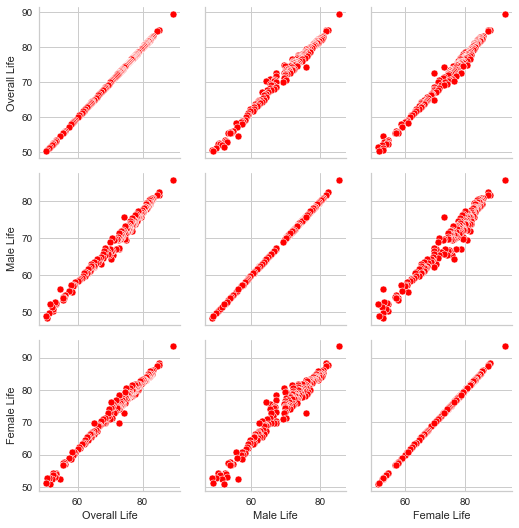

In [12]:
pair = sns.PairGrid(num_data, vars=['Overall Life', 'Male Life', 'Female Life'])
pair.map(sns.scatterplot, color='red');

# Analisis berdasarkan benua :

In [13]:
df['Continent'].value_counts()

Africa           55
Europe           51
Asia             49
North America    34
Oceania          20
South America    14
Name: Continent, dtype: int64

In [14]:
continent = df.groupby("Continent")['Overall Life'].describe()

In [15]:
continent

,count,mean,std,min,25%,50%,75%,max
Continent,,,,,,,,
Africa,55.0,61.800000,7.643298,50.2,55.650,61.70,64.900,79.5
Asia,49.0,73.618367,6.181244,51.3,70.100,74.60,77.200,85.0
Europe,51.0,79.019608,3.619835,70.7,76.200,80.20,81.750,89.5
North America,34.0,76.273529,4.012504,63.8,73.775,76.75,79.225,81.9
Oceania,20.0,74.230000,4.690876,66.2,72.850,74.50,77.325,82.2
South America,14.0,75.042857,3.194879,68.4,73.725,76.30,77.175,78.8


In [16]:
distribution = df[['Overall Life', 'Continent']]

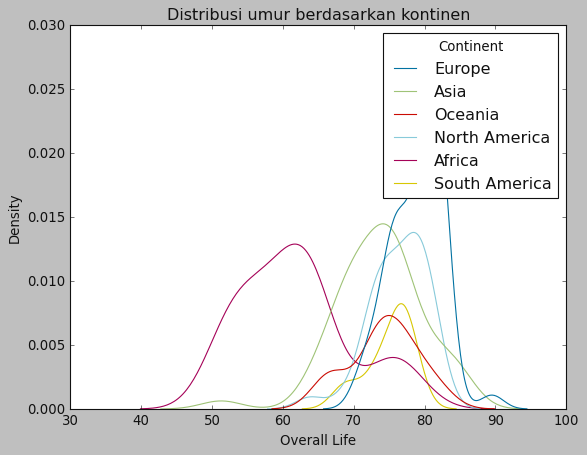

In [81]:
plt.title('Distribusi umur berdasarkan kontinen')
sns.kdeplot(x='Overall Life', hue='Continent',data=distribution);

- Kontinen Eropa dan Asia merupakan umur yang lebih panjang dibanding yang lain.
- Africa memiliki umur yang paling lebih dibanding yang lain.

# Berdasarkan negara dari setiap benua :

In [52]:
asia = df.loc[df['Continent'] == 'Asia']
eropa = df.loc[df['Continent'] == 'Europe']
afrika = df.loc[df['Continent'] == 'Africa']
oceania = df.loc[df['Continent'] == 'Oceania']
NA = df.loc[df['Continent'] == 'North America']
SA = df.loc[df['Continent'] == 'South America']

In [55]:
oceania.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,20.0,NaN,NaN,NaN,108.4,48.343508,14.0,70.75,117.5,137.0,173.0
Country,20,20,Solomon Islands,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,20.0,NaN,NaN,NaN,74.23,4.690876,66.2,72.85,74.5,77.325,82.2
Male Life,20.0,NaN,NaN,NaN,71.625,4.770399,63.0,69.975,72.1,74.75,79.8
Female Life,20.0,NaN,NaN,NaN,76.915,4.769782,68.8,75.075,77.3,79.9,84.8
Continent,20,1,Oceania,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
SA.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,14.0,NaN,NaN,NaN,100.857143,36.808981,51.0,74.25,88.0,126.5,164.0
Country,14,14,Aruba,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,14.0,NaN,NaN,NaN,75.042857,3.194879,68.4,73.725,76.3,77.175,78.8
Male Life,14.0,NaN,NaN,NaN,72.157143,3.174832,65.4,70.575,73.2,74.075,75.7
Female Life,14.0,NaN,NaN,NaN,77.992857,3.219762,71.5,76.3,79.3,79.975,81.9
Continent,14,1,South America,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
NA.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,34.0,NaN,NaN,NaN,87.147059,46.705481,17.0,49.0,81.0,127.5,186.0
Country,34,34,Montserrat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,34.0,NaN,NaN,NaN,76.273529,4.012504,63.8,73.775,76.75,79.225,81.9
Male Life,34.0,NaN,NaN,NaN,73.914706,3.874167,61.2,71.475,74.7,76.85,79.2
Female Life,34.0,NaN,NaN,NaN,78.738235,4.326242,66.4,75.6,79.45,81.975,84.6
Continent,34,1,North America,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
asia.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,49.0,NaN,NaN,NaN,112.836735,55.749195,2.0,71.0,119.0,157.0,221.0
Country,49,49,Thailand,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,49.0,NaN,NaN,NaN,73.618367,6.181244,51.3,70.1,74.6,77.2,85.0
Male Life,49.0,NaN,NaN,NaN,71.046939,6.218323,49.9,66.5,72.2,74.8,82.3
Female Life,49.0,NaN,NaN,NaN,76.138776,6.423713,52.7,72.9,77.0,79.4,88.5
Continent,49,1,Asia,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
eropa.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,51.0,NaN,NaN,NaN,56.313725,42.991855,1.0,21.5,39.0,87.5,153.0
Country,51,51,"France, metropolitan",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,51.0,NaN,NaN,NaN,79.019608,3.619835,70.7,76.2,80.2,81.75,89.5
Male Life,51.0,NaN,NaN,NaN,76.003922,4.201617,66.9,72.65,77.4,79.3,85.6
Female Life,51.0,NaN,NaN,NaN,82.237255,3.124481,74.8,80.3,82.8,84.2,93.5
Continent,51,1,Europe,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
afrika.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,55.0,NaN,NaN,NaN,182.4,41.885912,45.0,178.5,195.0,208.5,223.0
Country,55,55,Cameroon,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Life,55.0,NaN,NaN,NaN,61.8,7.643298,50.2,55.65,61.7,64.9,79.5
Male Life,55.0,NaN,NaN,NaN,60.109091,7.157779,48.6,54.55,59.7,62.55,76.6
Female Life,55.0,NaN,NaN,NaN,63.583636,8.275595,51.0,57.4,63.3,66.95,82.6
Continent,55,1,Africa,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
asia = asia.set_index('Rank')
eropa = eropa.set_index('Rank')
afrika = afrika.set_index('Rank')
NA = NA.set_index('Rank')
SA = SA.set_index('Rank')
oceania = oceania.set_index('Rank')

In [66]:
asia.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
2,Japan,85.0,81.7,88.5,Asia


In [67]:
eropa.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
1,Monaco,89.5,85.6,93.5,Europe


In [68]:
afrika.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
45,"Saint Helena, Ascension and Tristan da Cunha",79.5,76.6,82.6,Africa


In [69]:
NA.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
17,Canada,81.9,79.2,84.6,North America


In [70]:
SA.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
51,Chile,78.8,75.7,81.9,South America


In [71]:
oceania.head(1)

,Country,Overall Life,Male Life,Female Life,Continent
Rank,,,,,
14,Australia,82.2,79.8,84.8,Oceania


# PCA :

In [18]:
num_data = num_data.set_index('Rank')

In [19]:
X = num_data

In [20]:
pca= PCA(2)
pca.fit(X)

PCA(n_components=2)

In [21]:
X2D = pca.transform(X)

# Unsupervised Model Implementation :

# KMeans :

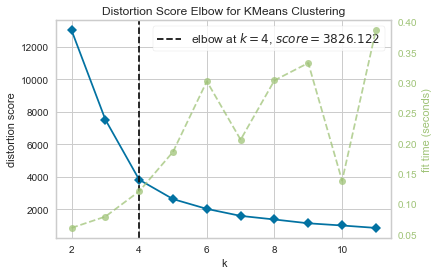

In [23]:
plt.figure(figsize=(6,4))
viz = KElbowVisualizer(kmeans, k=(2,12))
viz.fit(X2D)
viz.show();

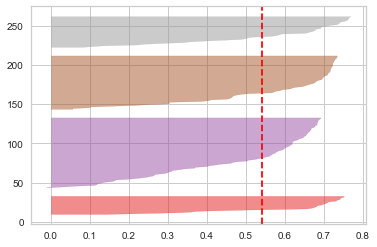

In [24]:
plt.figure(figsize=(6,4))
viskm = SilhouetteVisualizer(KMeans(4), color='yellowbrick')
viskm.fit(X2D);

In [78]:
kmeans = KMeans(random_state= 42, n_clusters= 4)
kmeans.fit(X2D)

KMeans(n_clusters=4, random_state=42)

In [79]:
kmlabel= kmeans.labels_
centroid = kmeans.cluster_centers_

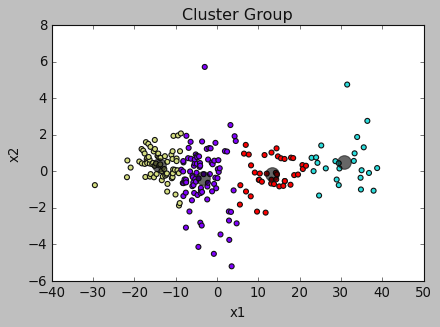

In [80]:
plt.figure(figsize=(6,4))
plt.scatter(X2D[:, 0], X2D[:, 1], c=kmlabel, cmap='rainbow')

plt.scatter(centroid[:, 0], centroid[:, 1], c='black', s=150, alpha=0.6);
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Cluster Group');

In [27]:
print("KMeans Silhouette Score : ", silhouette_score(X2D, kmlabel))

KMeans Silhouette Score :  0.45891010764581075


In [28]:
agg1 = AgglomerativeClustering(n_clusters=2)
agg1.fit(X2D)

AgglomerativeClustering()

In [29]:
agg1label = agg1.labels_

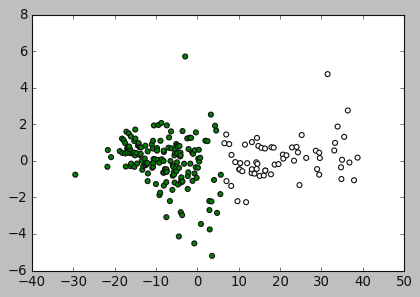

In [30]:
plt.figure(figsize=(6,4)) # hanya untuk melihat scoring dari clusters
plt.scatter(X2D[:,0], X2D[:,1], c=agg1label, cmap='ocean');

In [31]:
print(silhouette_score(X2D, agg1label))

0.6602462801877551


In [32]:
agg= AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg.fit(X2D)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [33]:
agglabel= agg.labels_

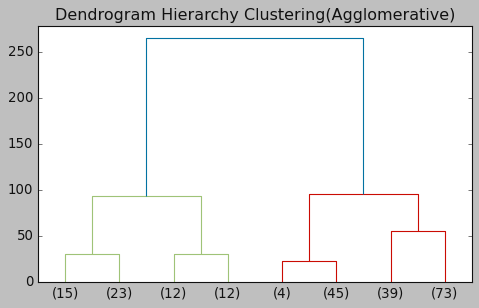

In [34]:
plt.figure(figsize=(7,4))
plot_dendrogram(agg, truncate_mode='level', p=2)
plt.title('Dendrogram Hierarchy Clustering(Agglomerative)');

# Model Evaluation :

# KMeans :
- KMeans mengelompokkan 4 kelompok, dimana kelompok ini menunjukkan life expectancy tiap kelompok (namun sudah di PCA), semakin ke kanan, maka semakin lama life expectancy nya.

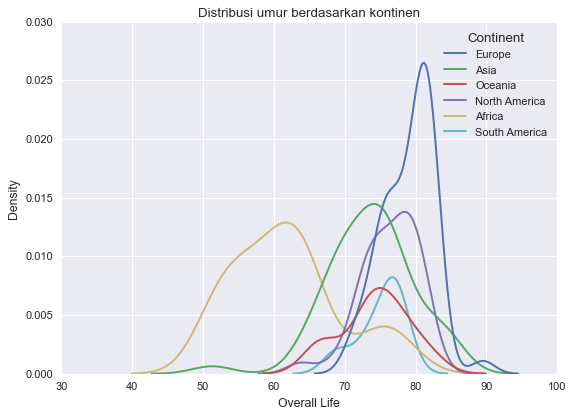

In [83]:
plt.style.use('seaborn')
plt.title('Distribusi umur berdasarkan kontinen')
sns.kdeplot(x='Overall Life', hue='Continent',data=distribution);

# Asumsi :
- kebanyakan negara yang berada di Eropa dan Asia terdistribusi di scatter warna merah dan biru muda, dikarenakan life expectancy dari Eropa dan Asia merupakan yang paling panjang di banding dengan negara lain.

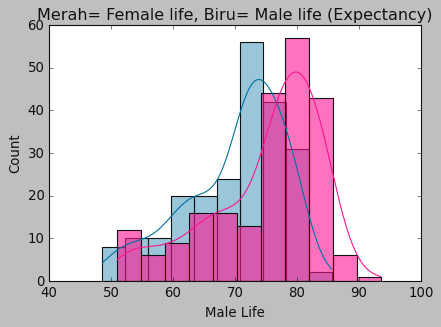

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Male Life', kde=True, alpha=0.4)
sns.histplot(data=df, x='Female Life', kde=True, color='deeppink', alpha=0.6)
plt.title('Merah= Female life, Biru= Male life (Expectancy)');

# Asumsi :

Isolation Forest mendeteksi kalau adanya kelompok yang berada di ujung kanan/ujung kiri distribusi.


yang berarti lebih lama/cepat tutup usia.

# Kesimpulan :

# Benua :
- Benua Eropa dan Asia merupakan umur yang lebih panjang dibanding yang lain.
- Africa memiliki umur yang paling lebih dibanding yang lain.

# Negara yang cenderung tutup usia lebih cepat berdasarkan kontinen :
- Oceania : Solomon Islands
- South America : Aruba
- North America : Montsterrat
- Asia : Thailand
- Eropa : Prancis
- Afrika : Cameroon

# Negara yang cenderung memiliki usia  terlama berdasarkan kontinen :
- Oceania : Australia
- South America : Chille
- North America : Canada
- Eropa : Monaco
- Asia : Jepang